# Import Data

In [ ]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
temperatures = df['T (degC)']
temperatures.index = df['Date Time']

<Axes: xlabel='Date Time'>

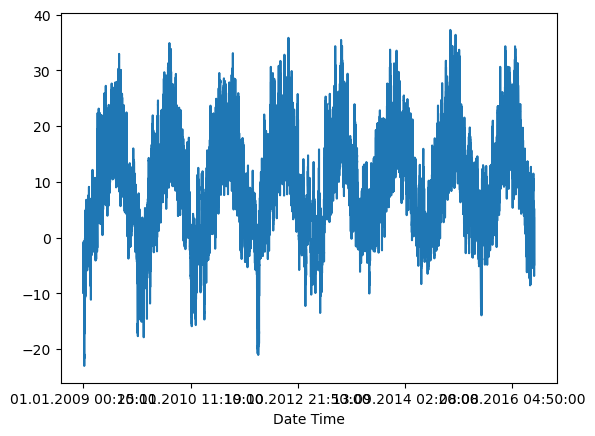

In [5]:
temperatures.plot()

# LSTM Model

In [6]:
import torch
import torch.nn as nn

In [7]:
num_features = 3
sequence_length = 10
batch_size = 2

x = torch.randn(batch_size, sequence_length, num_features)
x.size()

torch.Size([2, 10, 3])

In [8]:
lstm_layer = nn.LSTM(
    input_size = num_features,
    hidden_size = 8,
    num_layers = 4,
    batch_first = True, # False일 시 입력 형태: [시퀀스 길이, 배치 크기, 피처 개수]
)

In [9]:
y = lstm_layer(x)

In [10]:
y[0]

tensor([[[-0.1170, -0.0039, -0.0707,  0.1453, -0.0455,  0.0787, -0.0252,
           0.1104],
         [-0.1921, -0.0081, -0.1075,  0.2416, -0.0593,  0.1142, -0.0492,
           0.1763],
         [-0.2371, -0.0101, -0.1243,  0.3012, -0.0633,  0.1293, -0.0677,
           0.2132],
         [-0.2628, -0.0105, -0.1314,  0.3374, -0.0653,  0.1350, -0.0813,
           0.2336],
         [-0.2773, -0.0099, -0.1337,  0.3593, -0.0670,  0.1372, -0.0908,
           0.2446],
         [-0.2854, -0.0096, -0.1342,  0.3727, -0.0685,  0.1384, -0.0969,
           0.2506],
         [-0.2899, -0.0090, -0.1341,  0.3813, -0.0696,  0.1392, -0.1008,
           0.2539],
         [-0.2924, -0.0084, -0.1340,  0.3867, -0.0703,  0.1397, -0.1034,
           0.2556],
         [-0.2938, -0.0077, -0.1339,  0.3900, -0.0708,  0.1397, -0.1053,
           0.2567],
         [-0.2947, -0.0070, -0.1336,  0.3916, -0.0711,  0.1398, -0.1066,
           0.2571]],

        [[-0.1169, -0.0035, -0.0708,  0.1453, -0.0458,  0.0782, -0.0

In [11]:
output, (h_n, c_n) = lstm_layer(x)

In [12]:
output.size()

torch.Size([2, 10, 8])

In [13]:
h_n.size()

torch.Size([4, 2, 8])

In [14]:
c_n.size()

torch.Size([4, 2, 8])

In [15]:
print(output[:, -1, :])
print(h_n[-1, :, :])

tensor([[-0.2947, -0.0070, -0.1336,  0.3916, -0.0711,  0.1398, -0.1066,  0.2571],
        [-0.2947, -0.0079, -0.1336,  0.3920, -0.0711,  0.1399, -0.1059,  0.2573]],
       grad_fn=<SliceBackward0>)
tensor([[-0.2947, -0.0070, -0.1336,  0.3916, -0.0711,  0.1398, -0.1066,  0.2571],
        [-0.2947, -0.0079, -0.1336,  0.3920, -0.0711,  0.1399, -0.1059,  0.2573]],
       grad_fn=<SliceBackward0>)


In [16]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(3, 8, 4, batch_first=True)
        self.linear = nn.Linear(8, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        output = self.linear(lstm_output)

        return output

In [17]:
lstm_model = LSTMModel()
x = torch.randn(2, 10, 3)
y = lstm_model(x)

y.size()

torch.Size([2, 10, 1])

# Prepare Data

In [18]:
temperatures = df[['T (degC)']].to_numpy().astype(np.float32)
temperatures = temperatures[:50000]

In [19]:
num_data = len(temperatures)

train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

train_data = temperatures[:train_size]
val_data = temperatures[train_size:train_size + val_size]
test_data = temperatures[train_size + val_size:]

In [20]:
print(f'max: {train_data.max()}, min: {train_data.min()}')

max: 32.97999954223633, min: -23.010000228881836


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [22]:
print(f'max: {train_data_scaled.max():.4f}, min: {train_data_scaled.min():.4f}')
print(f'mean: {train_data_scaled.mean():.4f}, std: {train_data_scaled.std():.4f}')

max: 2.6188, min: -3.8247
mean: 0.0000, std: 1.0000


In [23]:
import torch
from torch.utils.data import Dataset

class JenaTemperatureDataset(Dataset):
    def __init__(self, temperatures, sequence_length):
        self.temperatures = temperatures
        self.sequence_length = sequence_length

    def __getitem__(self, index):
        inputs = self.temperatures[index:index+self.sequence_length]
        targets = self.temperatures[index+1:index+self.sequence_length+1]

        return torch.tensor(inputs), torch.tensor(targets)

    def __len__(self):
        return len(self.temperatures) - self.sequence_length

In [24]:
sequence_length = 24
train_dataset = JenaTemperatureDataset(train_data_scaled, sequence_length)
val_dataset = JenaTemperatureDataset(val_data_scaled, sequence_length)
test_dataset = JenaTemperatureDataset(test_data_scaled, sequence_length)

In [28]:
# 데이터로더
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

In [25]:
index = 0
print(f'original\n{train_data_scaled[:sequence_length+1]}\n')
print(f'inputs {index}\n{train_dataset[index][0]}\n')
print(f'targets {index}\n{train_dataset[index][1]}\n')

original
[[-2.0995972]
 [-2.144479 ]
 [-2.1559873]
 [-2.1329708]
 [-2.1283677]
 [-2.1030495]
 [-2.0535643]
 [-2.0535643]
 [-2.0869381]
 [-2.1467807]
 [-2.184758 ]]

inputs 0
tensor([[-2.0996],
        [-2.1445],
        [-2.1560],
        [-2.1330],
        [-2.1284],
        [-2.1030],
        [-2.0536],
        [-2.0536],
        [-2.0869],
        [-2.1468]])

targets 0
tensor([[-2.1445],
        [-2.1560],
        [-2.1330],
        [-2.1284],
        [-2.1030],
        [-2.0536],
        [-2.0536],
        [-2.0869],
        [-2.1468],
        [-2.1848]])



# Train the Model

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [29]:
# 모델
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        output = self.linear(lstm_output)

        return output


model = LSTMModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [30]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [31]:
epochs = 5
step = 0
for epoch in range(epochs):
    model.train()
    for train_batch in train_dataloader:
        inputs = train_batch[0].to(device)
        targets = train_batch[1].to(device)
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        step += 1
        if step % 100 == 0:
            print(f'step {step}, train loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_dataloader:
            inputs = val_batch[0].to(device)
            targets = val_batch[1].to(device)
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            losses.append(loss.item())

    val_loss_avg = sum(losses) / len(losses)
    print(f'\nepoch {epoch+1}/{epochs}, val loss: {val_loss_avg:.4f}\n')

step 100, train loss: 0.3457
step 200, train loss: 0.0548
step 300, train loss: 0.0171

epoch 1/5, val loss: 0.0053

step 400, train loss: 0.0065
step 500, train loss: 0.0035
step 600, train loss: 0.0020

epoch 2/5, val loss: 0.0010

step 700, train loss: 0.0022
step 800, train loss: 0.0015
step 900, train loss: 0.0023

epoch 3/5, val loss: 0.0008

step 1000, train loss: 0.0014
step 1100, train loss: 0.0012
step 1200, train loss: 0.0020

epoch 4/5, val loss: 0.0006

step 1300, train loss: 0.0012
step 1400, train loss: 0.0018
step 1500, train loss: 0.0011

epoch 5/5, val loss: 0.0005



In [32]:
test_preds = []
model.eval()
with torch.no_grad():
    for test_batch in test_dataloader:
        inputs = test_batch[0].to(device)
        preds = model(inputs) # [batch size, sequence length, 1]
        test_preds.append(preds[:, -1, :])

    test_preds = torch.cat(test_preds, dim=0)
    test_preds = test_preds.cpu().numpy()
    test_preds = scaler.inverse_transform(test_preds)

In [33]:
test_targets = test_data[sequence_length:]

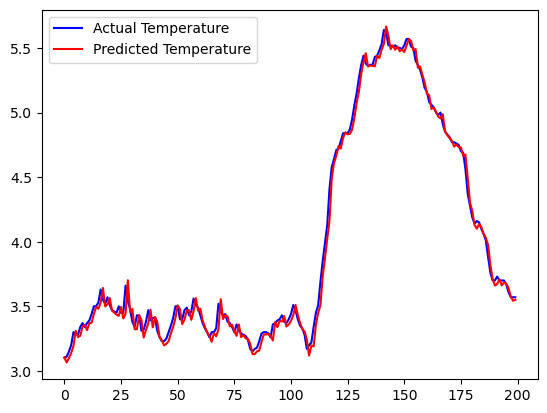

In [34]:
import matplotlib.pyplot as plt

plt.plot(test_targets[:200], color='blue', label='Actual Temperature')
plt.plot(test_preds[:200], color='red', label='Predicted Temperature')
plt.legend()
plt.show()